In [ ]:
!pip install leidenalg igraph networkit python-louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 48.8 MB/s eta 0:00:00


In [ ]:
import nltk
import kagglehub
import sys
import h5py
import random
import leidenalg
import json
import pickle
import community

import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkit as nk

from google.colab import files
from kagglehub.datasets import KaggleDatasetAdapter
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from scipy.sparse import csr_matrix, vstack
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")
original = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")
course.shape

/tmp/ipython-input-21-929910497.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")
/tmp/ipython-input-21-929910497.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  original = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")


(209734, 20)

In [ ]:
#fill missing last update date
def fill_empty_date(data, features):
  data = data.copy()
  for col in features:
    data[col] = pd.to_datetime(data[col], utc=True)

  published_date, updated_date = features
  data[updated_date] = data[updated_date].fillna(data[published_date])

  return data


#get latest 5 years data
def get_latest_five_years(data, features):
  data = data.copy()
  latest_year = data[features[0]].max().year
  last_five_year = latest_year - 5

  data = data[(data[features[0]].dt.year > last_five_year) & (data[features[1]].dt.year > last_five_year)]

  return data


#basic cleaning
def initial_cleaning_phase(course):
  course = course.copy()
  null_values = course[(course['num_lectures'] == 0) |
                (course['content_length_min'] == 0) |
                ((course['avg_rating'] == 0) & (course['num_reviews'] > 0))].index
  clean_data = course.drop(index=null_values).dropna()

  return clean_data

In [ ]:
course = course[course['language'].isin({'English'})]
course = fill_empty_date(course, features=['published_time', 'last_update_date'])
course = get_latest_five_years(course, features=['published_time', 'last_update_date'])
course = initial_cleaning_phase(course)
course['id'] = course['id'].astype(int)
print(course.shape)

(89225, 20)


In [ ]:
#separate numeric and non-numeric attributes
def get_numerical_attributes(data, exclude):
  numerical = []
  print(f"Numerical Attributes:")
  for num in data.select_dtypes(include = 'number').drop(columns='id').columns:
    if num != exclude:
      numerical.append(num)
      print(f"• {num}")

  return numerical


#label categorical values
def features_labeling(data, feature):
  label = data.copy()
  label['rounded_rating'] = (label[feature].copy()).astype(int)
  label['rating_label'] = label['rounded_rating'].apply(lambda x: 'bad' if x < 3 else ('mid' if x == 3 else 'good'))

  return label


#handle outliers using trim
def outlier_trimming(data, features, par, transforms=None):
  trim = data.copy()
  mask = set()

  for col in features:
    threshold = trim[col].quantile(par)
    mask.update(trim[trim[col] > threshold].index)

  trim = trim.drop(index=mask)
  transformed = trim.copy()
  if transforms:
    for cols, func in transforms:   #feature groups and math transformations
      for col in cols:  #features within a feature group
        transformed[col] = func(transformed[col])

  return trim, transformed


#scale data to uniform the scale
def data_scaling(data, features):
  scaler = MinMaxScaler()
  scaled = data.copy()
  scaled[features] = scaler.fit_transform(scaled[features])

  return scaled


#get years from datetime format
def convert_datetime_to_years(data, data_type='datetime64[ns, UTC]'):
  features = [col for col in data.select_dtypes(include=data_type)]
  for col in features:
    data[col] = data[col].dt.year.astype(str)

  return data


#check distributions
def box_visualization(data, features):
  sns.boxplot(data[features])
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
numerical = get_numerical_attributes(course, exclude='avg_rating')
course_completed = features_labeling(course, feature='avg_rating')

course_trim, course_transformed = outlier_trimming(
    course_completed,
    features=numerical,
    par=0.9,
    transforms=[
        (['num_subscribers', 'num_reviews', 'num_comments'], np.log1p),
        (['num_lectures', 'content_length_min'], np.cbrt),
        (['price'], np.sqrt)])

course_scaled = data_scaling(course_transformed, features=numerical)

Numerical Attributes:
• price
• num_subscribers
• num_reviews
• num_comments
• num_lectures
• content_length_min


In [ ]:
def get_redundant_features(data, features):
  correlation_scores = data[features].corr()
  upper = correlation_scores.where(np.triu(np.ones(correlation_scores.shape), k=1).astype(bool))
  redundant = [col for col in upper.columns if any(upper[col] > 0.85)]

  return redundant

In [ ]:
def trace_item_index(data, feature):
  new_order = data[feature].reset_index()
  new_order = new_order.rename(columns={'index': 'Raw index', 'id': 'Item ID'})

  return new_order

indices = trace_item_index(course_trim, feature='id')

In [ ]:
def semantic_preprocessing(data, features, id):
  def is_meaningful(token):
      if token in stop_words:
          return False
      if re.fullmatch(r'(19|20)\d{2}', token):  # allow years
          return True
      if token.isdigit():
          return False  # filter plain numbers
      if re.fullmatch(r'v?\d+', token):  # allow versions
          return True
      if re.search(r'\d+(kg|cm|ml)', token):  # keep measurement
          return True
      return token.isalpha()  # allow normal words

  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  combined_text =[]
  for col in features:
    semantic = data[col].str.lower()
    semantic = semantic.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if is_meaningful(word)]))
    combined_text.append(semantic)

  semantic = pd.concat(combined_text, axis=1).apply(lambda x: ' '.join(x), axis=1)

  vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.9, ngram_range=(1, 3), dtype=np.float32)
  tfidf_matrix = vectorizer.fit_transform(semantic)
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
  tfidf_df[id] = data[id].values
  tfidf_df = tfidf_df.set_index(id)

  return tfidf_matrix.toarray(), tfidf_df

In [ ]:
def numerical_preprocessing(data, features, id):
  junk = get_redundant_features(data, features) #get redundant numeric features
  numeric_df = data[features].drop(columns=junk)
  numeric_matrix = numeric_df.values
  numeric_df[id] = data[id].values
  numeric_df = numeric_df.set_index(id)

  return numeric_matrix, numeric_df

In [ ]:
def nominal_preprocessing(data, features, id):
  nominal = data[features].copy().reset_index(drop=True)
  nominal = convert_datetime_to_years(nominal)

  multiattribute_df = pd.get_dummies(nominal)
  multiattribute_matrix = multiattribute_df.values
  multiattribute_df[id] = data[id].values
  multiattribute_df = multiattribute_df.set_index(id)

  return multiattribute_matrix, multiattribute_df

In [ ]:
semantic_matrix, semantic_df = semantic_preprocessing(course_trim, features=['title', 'headline', 'topic'], id='id')
numeric_matrix, numeric_df = numerical_preprocessing(course_scaled, features=numerical, id='id')
nominal_matrix, nominal_df = nominal_preprocessing(course_trim, features=['is_paid', 'category', 'subcategory', 'rating_label', 'published_time', 'last_update_date'], id='id')

In [ ]:
def feature_combination(*data, form):
  initial = data[0]
  for i in data[1:]:
    if form =='df':
      initial = pd.concat([initial, i], axis=1)
    elif form == 'matrix':
      initial = np.concatenate((initial, i), axis=1)
    else:
      raise ValueError("form must be 'df' or 'matrix'")

  combined = initial

  return combined

In [ ]:
multiattribute_matrix = feature_combination(semantic_matrix, numeric_matrix, nominal_matrix, form='matrix')
multiattribute_df = feature_combination(semantic_df, numeric_df, nominal_df, form='df')
index_to_node = multiattribute_df.index.to_list()

In [ ]:
print(f'Matrix shape: {multiattribute_matrix.shape}')
print(f'Matrix size: {sys.getsizeof(multiattribute_matrix)/1000000} MB')

Matrix shape: (65845, 1162)
Matrix size: 612.095248 MB


In [ ]:
def single_multiattributes_pipeline_batched(data, group_sizes, block_size, output_path='multiattribute_similarity_refined.h5', cos_weight=1.0, euc_weight=1.0, dic_weights=None):
  block_ranges = [slice(sum(group_sizes[:i]), sum(group_sizes[:i+1])) for i in range(len(group_sizes))]
  N = len(data)

  semantic_block = data[:, block_ranges[0]]
  numeric_block = data[:, block_ranges[1]]
  nominal_ranges = block_ranges[2:]

  # Set equal weights for dice if not provided
  if dic_weights is None:
    dic_weights = [1.0] * len(nominal_ranges)

  with h5py.File(output_path, 'w') as f:
    sim_matrix = f.create_dataset('similarity', shape=(N, N), dtype='float32')

    for start in range(0, N, block_size):
      end = min(start + block_size, N)
      print(f"Processing block {start}:{end}")

      # 1. Semantic
      semantic_block_part = semantic_block[start:end]
      semantic_sim = cosine_similarity(semantic_block_part, semantic_block)
      semantic_valid = np.ones_like(semantic_sim)  # Placeholder: 1s if present

      # 2. Numeric
      numeric_block_part = numeric_block[start:end]
      numeric_dist = euclidean_distances(numeric_block_part, numeric_block)
      numeric_sim = 1 / (1 + numeric_dist)
      numeric_valid = np.ones_like(numeric_sim)  # Placeholder

      # 3. Nominal (Dice)
      dice_sims = []
      dice_valids = []
      for nominal_slice in nominal_ranges:
        nom_all = data[:, nominal_slice]
        nom_part = nom_all[start:end, :]

        ni = nom_part.sum(axis=1)
        nj = nom_all.sum(axis=1)
        nij = nom_part @ nom_all.T

        denom = ni[:, None] + nj[None, :]
        denom[denom == 0] = 1e-12

        dice = (2 * nij) / denom
        dice_sims.append(dice)

        valid = (ni[:, None] > 0) & (nj[None, :] > 0)
        dice_valids.append(valid.astype(float))

      # Combine using weighted fusion
      weighted_sum = cos_weight * semantic_sim + euc_weight * numeric_sim
      weight_sum = cos_weight * semantic_valid + euc_weight * numeric_valid

      for dice_sim, dice_valid, weight in zip(dice_sims, dice_valids, dic_weights):
        weighted_sum += weight * dice_sim
        weight_sum += weight * dice_valid

      weight_sum[weight_sum == 0] = 1e-12
      multiattribute_similarity = weighted_sum / weight_sum

      # Optionally zero out lower triangle
      for i in range(end - start):
          abs_row = start + i
          multiattribute_similarity[i, :abs_row] = 0.0

      sim_matrix[start:end, :] = multiattribute_similarity

  print(f"Done! Similarity matrix saved in: {output_path}")


# Example usage:
group_sizes = [1000, 5, 1, 13, 130, 3, 5, 5]
single_multiattributes_pipeline_batched(data=multiattribute_matrix, group_sizes=group_sizes, block_size=1500)

In [ ]:
with h5py.File('multiattribute_similarity_refined.h5', 'r') as f:
    sim_matrix = f['similarity'][6:14, 6:14]  # This is likely a NumPy array

    np.set_printoptions(linewidth=200)  # Increase line width before printing
    print(sim_matrix)

In [ ]:
class UnionFind:
  def __init__(self, elements):
    self.parent = {e: e for e in elements}
    self.rank = {e: 0 for e in elements}

  def find(self, x):
    if self.parent[x] != x:
      self.parent[x] = self.find(self.parent[x]) # Path compression
    return self.parent[x]

  def union(self, x, y):
    rootX = self.find(x)
    rootY = self.find(y)

    if rootX != rootY:
      if self.rank[rootX] < self.rank[rootY]:
        self.parent[rootX] = rootY
      elif self.rank[rootX] > self.rank[rootY]:
        self.parent[rootY] = rootX
      else:
        self.parent[rootY] = rootX
        self.rank[rootX] += 1
      return True # Successfully united, no cycle formed
    return False # Already in the same set, would form a cycle


def construct_max_spanning_tree_from_similarity_optimized(h5_file, index_to_node, similarity_threshold):
  MST_graph = nx.Graph()

  with h5py.File(h5_file, 'r') as f:
    sim_matrix = f['similarity']
    N = sim_matrix.shape[0]

    MST_graph.add_nodes_from(index_to_node)
    uf = UnionFind(index_to_node)

    print(f"Collecting and sorting potential edges with similarity > {similarity_threshold}...")

    edges_flat = []
    for i in range(N):
      row = sim_matrix[i, i+1:]
      valid_indices_in_row = np.where(row > similarity_threshold)[0]
      for idx in valid_indices_in_row:
        j = i + 1 + idx
        weight = row[idx]
        edges_flat.append((weight, index_to_node[i], index_to_node[j]))

    print(f"Collected {len(edges_flat)} potential edges. Sorting them by weight (descending)...")

    edges_flat.sort(key=lambda x: x[0], reverse=True) # x[0] is the weight

    edges_added_count = 0
    total_nodes = len(index_to_node)

    print("Applying Kruskal's algorithm to form MST/MSF...")
    for weight, u, v in edges_flat:
      if uf.union(u, v):
        MST_graph.add_edge(u, v, weight=weight)
        edges_added_count += 1

        if edges_added_count == total_nodes - 1:
          pass # Keep going to ensure all components are built into trees

  print(f"MST construction complete. Resulting graph has {MST_graph.number_of_nodes()} nodes and {MST_graph.number_of_edges()} edges.")

  if not nx.is_tree(MST_graph):
    print("Note: Resulting graph is a Maximum Spanning Forest (MSF) not a single tree.")
    is_all_components_trees = True

    for i, component_nodes in enumerate(nx.connected_components(MST_graph)):
      subgraph_component = MST_graph.subgraph(component_nodes)

      if not nx.is_tree(subgraph_component):
        print(f"Critical Error: Connected component {i+1} is not a tree!")
        is_all_components_trees = False
        break

    if is_all_components_trees:
      print("All connected components in the MSF are indeed trees (as expected).")
  else:
    print("The resulting graph is a single Maximum Spanning Tree (MST).")

  return MST_graph


G = construct_max_spanning_tree_from_similarity_optimized('multiattribute_similarity_refined.h5', index_to_node, similarity_threshold=0.5)
with open('G.pkl', 'wb') as f:
   pickle.dump(G, f)

Graphviz not available. Using Kamada-Kawai layout.


/tmp/ipython-input-108-1391863832.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Greys')  # From light gray to black


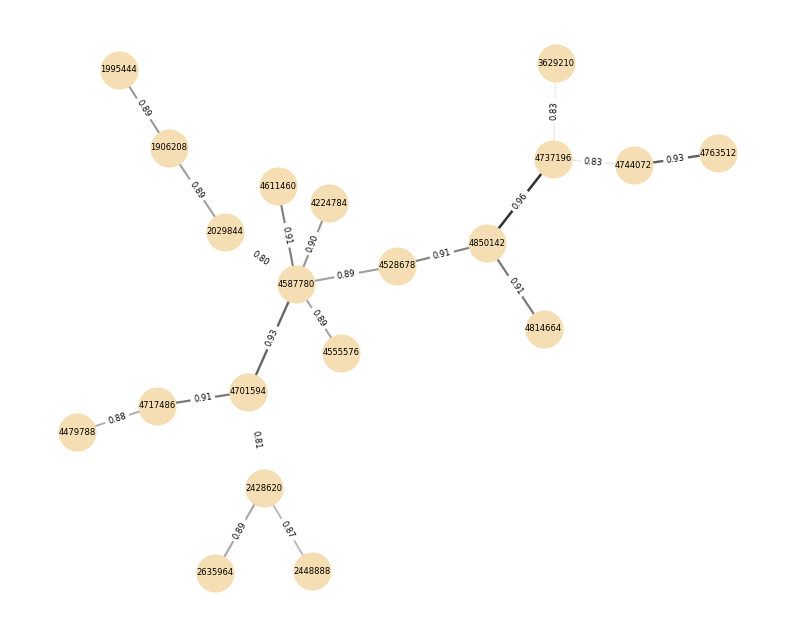

In [ ]:
def basic_network_graph(G, sample_size=30, start_node=None):
  if start_node is None:
      start_node = random.choice(list(G.nodes()))
  visited = set()
  queue = [start_node]
  while queue and len(visited) < sample_size:
      node = queue.pop(0)
      if node not in visited:
          visited.add(node)
          neighbors = list(G.neighbors(node))
          random.shuffle(neighbors)
          queue.extend([n for n in neighbors if n not in visited])
  sampled_nodes = list(visited)
  G_sub = G.subgraph(sampled_nodes).copy()

  edge_weights = [G_sub[u][v].get('weight', 1.0) for u, v in G_sub.edges()]
  min_display_weight = 0.8
  max_display_weight = 0.99
  weight_range = max_display_weight - min_display_weight
  norm_weights = [
      min(max((w - min_display_weight) / weight_range, 0.0), 1.0)
      for w in edge_weights]
  widths = [1 + 1 * nw for nw in norm_weights]
  cmap = cm.get_cmap('Greys')  # From light gray to black
  edge_colors = [cmap(nw) for nw in norm_weights]

  # Step 3: Plotting
  plt.figure(figsize=(10, 8))
  try:
      from networkx.drawing.nx_agraph import graphviz_layout
      pos = graphviz_layout(G_sub, prog='dot')  # tree layout
  except ImportError:
      print("Graphviz not available. Using Kamada-Kawai layout.")
      pos = nx.kamada_kawai_layout(G_sub)

  integer_nodes = {node: int(node) for node in G_sub.nodes()}
  edge_labels = {(u, v): f"{G_sub[u][v].get('weight', 1.0):.2f}" for u, v in G_sub.edges()}

  nx.draw_networkx_nodes(G_sub, pos, node_size=700, node_color='wheat')
  nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, width=widths)
  nx.draw_networkx_labels(G_sub, pos, labels=integer_nodes, font_size=6)
  nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=6)

  plt.axis('off')
  plt.show()


basic_network_graph(G, sample_size=20)

Graphviz not available. Using Kamada-Kawai layout.


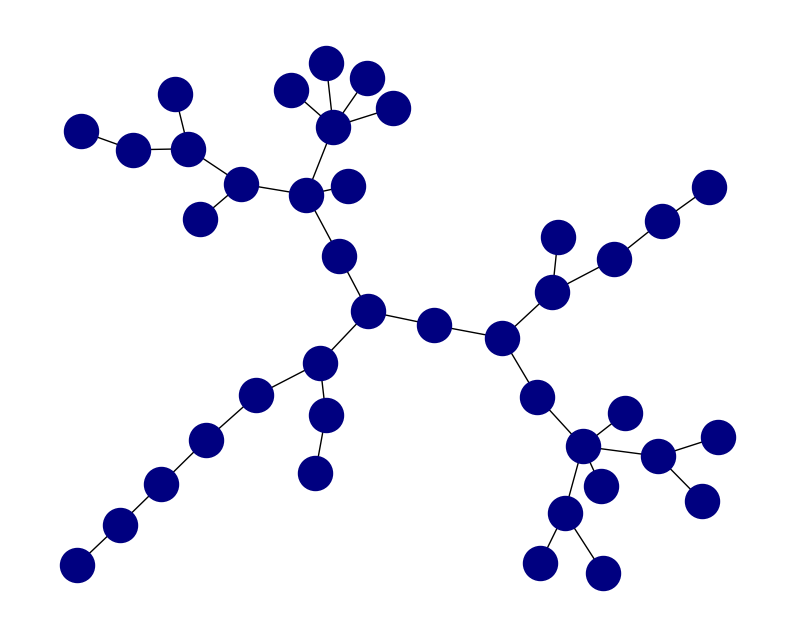

In [ ]:
def big_sample_network_graph(G, sample_size=30, start_node=None):
  # Step 1: Sample connected nodes via BFS
  if start_node is None:
      start_node = random.choice(list(G.nodes()))
  visited = set()
  queue = [start_node]
  while queue and len(visited) < sample_size:
      node = queue.pop(0)
      if node not in visited:
          visited.add(node)
          neighbors = list(G.neighbors(node))
          random.shuffle(neighbors)
          queue.extend([n for n in neighbors if n not in visited])
  sampled_nodes = list(visited)
  G_sub = G.subgraph(sampled_nodes).copy()

  plt.figure(figsize=(10, 8))
  try:
    from networkx.drawing.nx_agraph import graphviz_layout
    pos = graphviz_layout(G_sub, prog='dot')
  except ImportError:
      print("Graphviz not available. Using Kamada-Kawai layout.")
      pos = nx.kamada_kawai_layout(G_sub)

  nx.draw_networkx_nodes(G_sub, pos, node_size=600, node_color='navy')
  nx.draw_networkx_edges(G_sub, pos, edge_color='black')

  plt.axis('off')
  plt.show()


big_sample_network_graph(G, sample_size=40, start_node=None)

In [ ]:
def leiden_community_detection(G, partition_type=leidenalg.ModularityVertexPartition):
    G_igraph = ig.Graph.from_networkx(G)
    G_igraph.vs['name'] = list(G.nodes())

    partition = leidenalg.find_partition(G_igraph, partition_type)
    membership = partition.membership
    print(f"Number of communities: {len(partition)}")

    modularity_score = partition.modularity
    print(f"Modularity Score: {modularity_score:.3f}")

    intra_edges = 0
    total_edges = len(G_igraph.es)
    for edge in G_igraph.es:
        src, tgt = edge.tuple
        if membership[src] == membership[tgt]:
            intra_edges += 1
    coverage = intra_edges / total_edges
    print(f"Coverage: {coverage:.3f}")

    community_sizes = [len(c) for c in partition]
    max_idx, max_size = max(enumerate(community_sizes), key=lambda x: x[1])
    print(f"Largest Community: Community {max_idx} with {max_size} nodes")
    min_idx, min_size = min(enumerate(community_sizes), key=lambda x: x[1])
    print(f"Smallest Community: Community {min_idx} with {min_size} nodes")

    # ✅ Build node-to-cluster mapping
    node_to_cluster = {}
    for idx, node in enumerate(G_igraph.vs['name']):  # 'name' retains original NetworkX node IDs
        node_to_cluster[int(node)] = membership[idx]


    # ✅ Check for unassigned nodes
    original_nodes = set(G.nodes())
    assigned_nodes = set(node_to_cluster.keys())
    unassigned_nodes = original_nodes - assigned_nodes

    if unassigned_nodes:
        print(f"⚠️ Warning: {len(unassigned_nodes)} nodes not assigned to any community.")
        print(f"Unassigned nodes: {unassigned_nodes}")
    else:
        print("✅ All nodes are assigned to a community.")

    return node_to_cluster


node_to_cluster = leiden_community_detection(G, leidenalg.ModularityVertexPartition)
with open('community_mapping.pkl', 'wb') as f:
  pickle.dump(node_to_cluster, f)

Number of communities: 264
Modularity Score: 0.992
Coverage: 0.996
Largest Community: Community 0 with 390 nodes
Smallest Community: Community 263 with 121 nodes
✅ All nodes are assigned to a community.


In [ ]:
def leiden_community_detection(G, partition_type=leidenalg.ModularityVertexPartition):
    # Convert to igraph
    G_igraph = ig.Graph.from_networkx(G)
    G_igraph.vs['name'] = list(G.nodes())

    # Run Leiden algorithm
    partition = leidenalg.find_partition(G_igraph, partition_type)
    membership = partition.membership
    print(f"Number of communities: {len(partition)}")

    # Modularity
    modularity_score = partition.modularity
    print(f"Modularity Score: {modularity_score:.3f}")

    # Coverage
    intra_edges = 0
    total_edges = len(G_igraph.es)
    for edge in G_igraph.es:
        src, tgt = edge.tuple
        if membership[src] == membership[tgt]:
            intra_edges += 1
    coverage = intra_edges / total_edges
    print(f"Coverage: {coverage:.3f}")

    # Community sizes
    community_sizes = [len(c) for c in partition]
    max_idx, max_size = max(enumerate(community_sizes), key=lambda x: x[1])
    min_idx, min_size = min(enumerate(community_sizes), key=lambda x: x[1])
    print(f"Largest Community: Community {max_idx} with {max_size} nodes")
    print(f"Smallest Community: Community {min_idx} with {min_size} nodes")

    # Node to cluster mapping
    node_to_cluster = {
        int(node): membership[idx]
        for idx, node in enumerate(G_igraph.vs['name'])
    }

    # Unassigned node check
    original_nodes = set(G.nodes())
    assigned_nodes = set(node_to_cluster.keys())
    unassigned_nodes = original_nodes - assigned_nodes

    if unassigned_nodes:
        print(f"⚠️ Warning: {len(unassigned_nodes)} nodes not assigned to any community.")
        print(f"Unassigned nodes: {unassigned_nodes}")
    else:
        print("✅ All nodes are assigned to a community.")

    # 🔍 Conductance calculation
    conductance_scores = {}
    cluster_ids = set(node_to_cluster.values())

    for community_id in cluster_ids:
        community_nodes = [n for n, c in node_to_cluster.items() if c == community_id]
        boundary_cut = 0
        volume = 0

        for node in community_nodes:
            for neighbor in G.neighbors(node):
                volume += 1
                if node_to_cluster[neighbor] != community_id:
                    boundary_cut += 1

        outside_nodes = set(G.nodes()) - set(community_nodes)
        outside_volume = sum(dict(G.degree(outside_nodes)).values())

        denominator = min(volume, outside_volume)
        conductance = boundary_cut / denominator if denominator > 0 else 0
        conductance_scores[community_id] = conductance

    avg_conductance = sum(conductance_scores.values()) / len(conductance_scores)
    print(f"Average Conductance: {avg_conductance:.3f}")


leiden_community_detection(G, partition_type=leidenalg.ModularityVertexPartition)

Number of communities: 262
Modularity Score: 0.992
Coverage: 0.996
Largest Community: Community 0 with 369 nodes
Smallest Community: Community 261 with 137 nodes
✅ All nodes are assigned to a community.
Average Conductance: 0.004


In [ ]:
import itertools
from sklearn.metrics import normalized_mutual_info_score

def leiden_community_detection(G, node_to_cluster, partition_type, check_stability=True, resolution_range=None):
  G_igraph = ig.Graph.from_networkx(G)
  G_igraph.vs['name'] = list(G.nodes())

  # --- Base Partition ---
  partition = leidenalg.find_partition(G_igraph, partition_type)
  membership = partition.membership
  print(f"Number of communities: {len(partition)}")

  modularity_score = partition.modularity
  print(f"Modularity Score: {modularity_score:.3f}")

  # --- Intra-Edges ---
  intra_edges = 0
  cut_edges = 0
  total_edges = len(G_igraph.es)
  for edge in G_igraph.es:
      src, tgt = edge.tuple
      if membership[src] == membership[tgt]:
          intra_edges += 1
      else:
          cut_edges += 1
  coverage = intra_edges / total_edges
  print(f"Coverage: {coverage:.3f}")
  print(f"Cut Size: {cut_edges} edges between communities")

  # --- Conductance
  conductance_scores = {}
  cluster_ids = set(node_to_cluster.values())

  for community_id in cluster_ids:
    community_nodes = [n for n, c in node_to_cluster.items() if c == community_id]
    boundary_cut = 0
    volume = 0

    for node in community_nodes:
        for neighbor in G.neighbors(node):
            volume += 1
            if node_to_cluster[neighbor] != community_id:
                boundary_cut += 1

    outside_nodes = set(G.nodes()) - set(community_nodes)
    outside_volume = sum(dict(G.degree(outside_nodes)).values())

    denominator = min(volume, outside_volume)
    conductance = boundary_cut / denominator if denominator > 0 else 0
    conductance_scores[community_id] = conductance

  avg_conductance = sum(conductance_scores.values()) / len(conductance_scores)
  print(f"Average Conductance: {avg_conductance:.3f}")

  # --- Performance ---
  f = intra_edges
  g = 0
  nodes = list(G.nodes())
  n = len(nodes)

  for u, v in itertools.combinations(nodes, 2):
      if node_to_cluster[u] != node_to_cluster[v] and not G.has_edge(u, v):
          g += 1

  perf = (f + g) / (0.5 * n * (n - 1))
  print(f"Performance Score: {perf:.3f}")

  # --- Community Sizes ---
  community_sizes = [len(c) for c in partition]
  max_idx, max_size = max(enumerate(community_sizes), key=lambda x: x[1])
  print(f"Largest Community: Community {max_idx} with {max_size} nodes")
  min_idx, min_size = min(enumerate(community_sizes), key=lambda x: x[1])
  print(f"Smallest Community: Community {min_idx} with {min_size} nodes")

  # --- Mapping ---
  node_to_cluster = {}
  for idx, node in enumerate(G_igraph.vs['name']):
      node_to_cluster[int(node)] = membership[idx]

  original_nodes = set(G.nodes())
  assigned_nodes = set(node_to_cluster.keys())
  unassigned_nodes = original_nodes - assigned_nodes

  if unassigned_nodes:
      print(f"⚠️ Warning: {len(unassigned_nodes)} nodes not assigned to any community.")
      print(f"Unassigned nodes: {unassigned_nodes}")
  else:
      print("✅ All nodes are assigned to a community.")


  result = pd.DataFrame({
      "modularity": [modularity_score:.3f],
      "coverage": [coverage:.3f],
      "conductance": [avg_conductance:.3f],
      "performance": [perf]
  })


leiden_community_detection(G, node_to_cluster, leidenalg.RBConfigurationVertexPartition, check_stability=True, resolution_range=np.linspace(0.2, 2.0, 10))

[GLOBAL] Leiden modularity Q = 0.992 | Communities = 264
[INFO] Found 40 connected nodes covering 3 communities.


/tmp/ipython-input-28-1693153968.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(unique_communities))


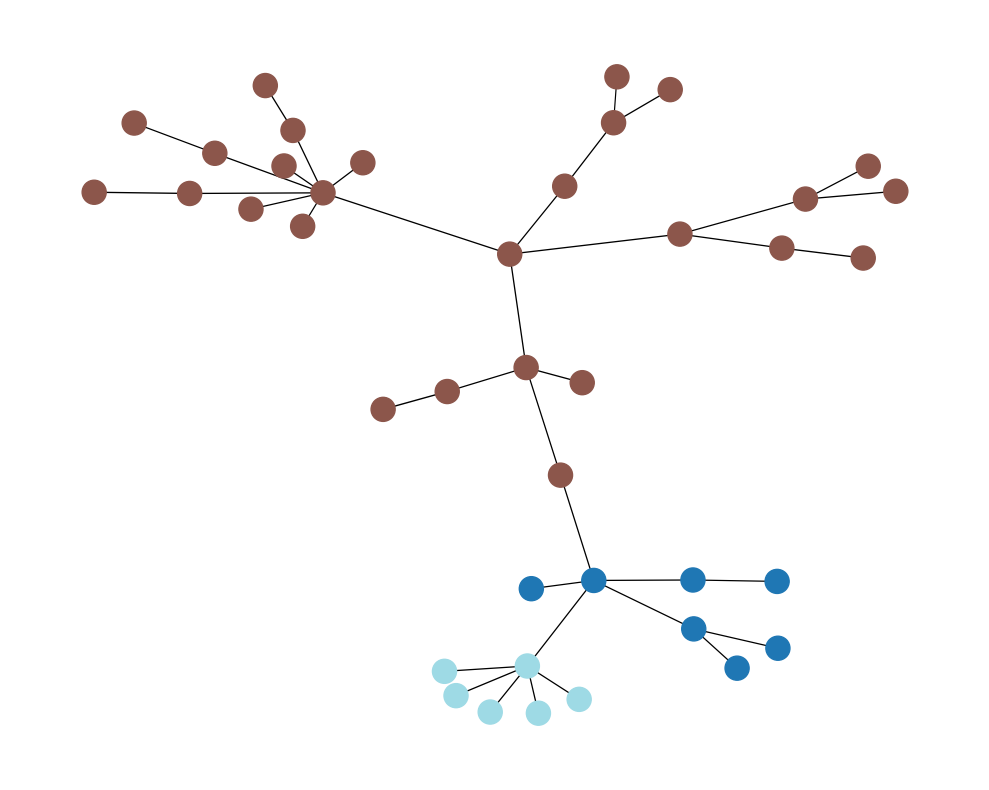

In [ ]:
def network_graph_bfs_min_communities(G, sample_size=40, min_communities=2, start_node=None):
    # Step 1: Run Leiden
    G_full_igraph = ig.Graph.from_networkx(G)
    G_full_igraph.vs['name'] = list(G.nodes())
    partition = leidenalg.find_partition(G_full_igraph, leidenalg.ModularityVertexPartition)
    global_membership = partition.membership
    modularity = partition.modularity
    print(f"[GLOBAL] Leiden modularity Q = {modularity:.3f} | Communities = {len(set(global_membership))}")

    # Node-to-community mapping
    node_list = G_full_igraph.vs['name']
    community_dict = dict(zip(node_list, global_membership))

    # Step 2: Sample connected nodes via BFS with min_community constraint
    attempt = 0
    max_attempts = 100

    while attempt < max_attempts:
        visited = set()
        community_set = set()
        if start_node is None:
            start_node = random.choice(list(G.nodes()))
        queue = [start_node]

        while queue and len(visited) < sample_size:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                community_set.add(community_dict[node])
                neighbors = list(G.neighbors(node))
                random.shuffle(neighbors)
                queue.extend([n for n in neighbors if n not in visited])

        if len(visited) >= sample_size and len(community_set) >= min_communities:
            print(f"[INFO] Found {len(visited)} connected nodes covering {len(community_set)} communities.")
            break
        attempt += 1
        start_node = None  # Retry with new random start node

    if attempt == max_attempts:
        print(f"[WARNING] Could not find {sample_size} connected nodes with ≥{min_communities} communities.")
        return

    sampled_nodes = list(visited)
    G_sub = G.subgraph(sampled_nodes).copy()

    # Step 3: Assign colors
    sampled_communities = [community_dict[n] for n in G_sub.nodes()]
    unique_communities = list(set(sampled_communities))
    color_map = cm.get_cmap('tab20', len(unique_communities))
    comm_color_lookup = {comm: color_map(i) for i, comm in enumerate(unique_communities)}
    node_colors = [comm_color_lookup[community_dict[n]] for n in G_sub.nodes()]

    # Step 4: Plotting
    edge_weights = [G[u][v].get('weight', 1.0) for u, v in G_sub.edges()]
    max_weight = max(edge_weights) if edge_weights else 1.0
    widths = [1 * (w / max_weight) for w in edge_weights]

    plt.figure(figsize=(10, 8))
    # Reduce node overlap: increase repulsion force (k), and more iterations
    k = 2.5 / np.sqrt(len(G_sub.nodes()))
    pos = nx.spring_layout(G_sub, seed=42, k=k, iterations=500)

    # Optional integer label conversion
    integer_labels = {}
    for node in G_sub.nodes():
        try:
            integer_labels[node] = int(float(node))
        except:
            integer_labels[node] = node  # fallback if not numeric

    nx.draw_networkx_nodes(G_sub, pos,
                           node_color=node_colors,
                           node_size=300)
    nx.draw_networkx_edges(G_sub, pos,
                           width=widths,
                           edge_color='black')
    # nx.draw_networkx_labels(G_sub, pos,
    #                         labels=integer_labels,
    #                         font_size=6)
    # plt.title(f"BFS Sample ({sample_size} nodes) with ≥{min_communities} Communities (Q={modularity:.3f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


network_graph_bfs_min_communities(G, sample_size=40, min_communities=2)

[GLOBAL] Leiden Q=0.992 | Total communities: 265


/tmp/ipython-input-119-1443866586.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', sample_size)


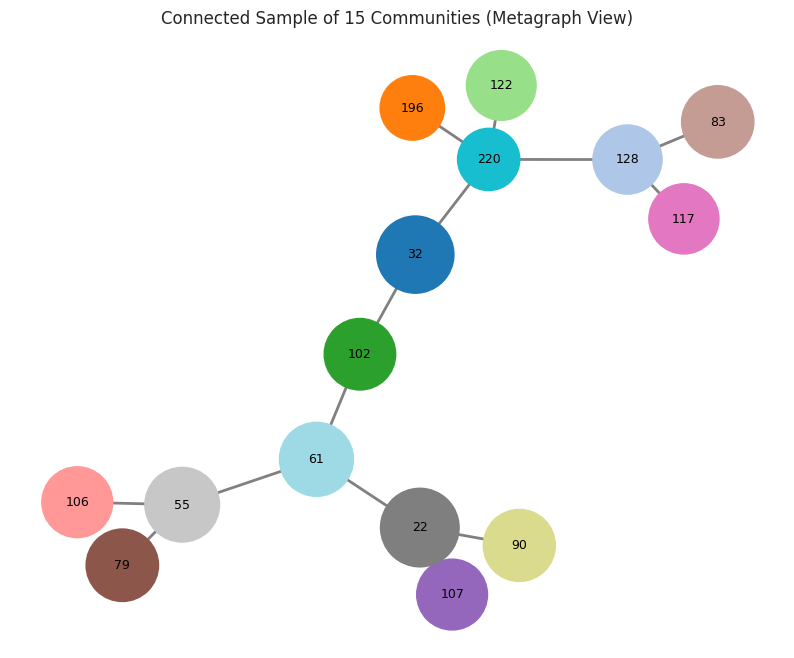

In [ ]:
def visualize_connected_metagraph_sample(G, sample_size=30, seed=42):
  G_ig = ig.Graph.from_networkx(G)
  G_ig.vs['name'] = list(G.nodes())
  partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)
  membership = partition.membership
  node_to_comm = dict(zip(G_ig.vs['name'], membership))
  comm_counts = Counter(membership)
  print(f"[GLOBAL] Leiden Q={partition.modularity:.3f} | Total communities: {len(comm_counts)}")

  # Step 2: Build metagraph
  metagraph = nx.Graph()
  for comm in comm_counts:
      metagraph.add_node(comm, size=comm_counts[comm])

  for u, v in G.edges():
      cu, cv = node_to_comm[u], node_to_comm[v]
      if cu != cv:
          if metagraph.has_edge(cu, cv):
              metagraph[cu][cv]['weight'] += 1
          else:
              metagraph.add_edge(cu, cv, weight=1)

  # Step 3: Find connected components
  connected_components = list(nx.connected_components(metagraph))
  connected_components.sort(key=len, reverse=True)  # largest first

  # Step 4: Sample from largest component using BFS
  largest_cc = connected_components[0]
  start_comm = random.choice(list(largest_cc))
  visited = set()
  queue = [start_comm]
  while queue and len(visited) < sample_size:
      comm = queue.pop(0)
      if comm not in visited:
          visited.add(comm)
          neighbors = list(metagraph.neighbors(comm))
          random.shuffle(neighbors)
          queue.extend([n for n in neighbors if n not in visited])

  sampled_communities = list(visited)
  sub_metagraph = metagraph.subgraph(sampled_communities).copy()

  # Step 5: Plot
  pos = nx.spring_layout(sub_metagraph, seed=seed)
  sizes = [sub_metagraph.nodes[n]['size'] * 10 for n in sub_metagraph.nodes()]
  weights = [sub_metagraph[u][v]['weight'] for u, v in sub_metagraph.edges()]
  max_weight = max(weights) if weights else 1.0
  widths = [2 * (w / max_weight) for w in weights]

  plt.figure(figsize=(10, 8))
  cmap = cm.get_cmap('tab20', sample_size)
  node_colors = [cmap(i % 20) for i, _ in enumerate(sub_metagraph.nodes())]

  nx.draw_networkx_nodes(sub_metagraph, pos, node_size=sizes, node_color=node_colors)
  nx.draw_networkx_edges(sub_metagraph, pos, width=widths, edge_color='gray')
  nx.draw_networkx_labels(sub_metagraph, pos, font_size=9, font_color='black')
  plt.title(f"Connected Sample of {sample_size} Communities (Metagraph View)")
  plt.axis('off')
  plt.show()


visualize_connected_metagraph_sample(G, sample_size=15)

In [ ]:
def centrality_metrics_networkit_weighted(G_nx):
  # Konversi similarity → distance
  for u, v, data in G_nx.edges(data=True):
      sim = data.get('weight', 1.0)
      distance = 1.0 - sim + 1e-6 #untuk menghindari 0
      data['weight'] = distance

  def minmax_normalization(x):
    return (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else np.zeros_like(x)

  G_nk = nk.nxadapter.nx2nk(G_nx, weightAttr="weight")
  n = G_nk.numberOfNodes()

  # Weighted Degree Centrality (strength)
  weighted_deg = np.zeros(n)
  for u in range(n):
    for v in G_nk.iterNeighbors(u):
      weighted_deg[u] += G_nk.weight(u, v)

  # Normalize weighted degree: divide by max possible (n-1 * max weight)
  max_weight = max([G_nk.weight(u, v) for u in range(n) for v in G_nk.iterNeighbors(u)])
  weighted_deg_norm = weighted_deg / ((n - 1) * max_weight) if max_weight > 0 else np.zeros_like(weighted_deg)

  # Weighted Closeness Centrality
  closeness = nk.centrality.Closeness(G_nk, True, nk.centrality.ClosenessVariant.GENERALIZED)
  closeness.run()
  clo = np.array(closeness.scores())

  # Normalize closeness using standard formula
  # C(i) = (n - 1) / sum of distances
  clo_norm = minmax_normalization(clo)

  # Weighted Betweenness Centrality
  betweenness = nk.centrality.Betweenness(G_nk, normalized=True)
  betweenness.run()
  bet = np.array(betweenness.scores())  # Already normalized

  # Composite Score: average of the three normalized centralities
  avg_norm = (weighted_deg_norm + clo_norm + bet) / 3

  centrality_result = pd.DataFrame({
      'node_id': list(G_nx.nodes()),
      'degree': weighted_deg_norm,
      'closeness': clo_norm,
      'betweenness': bet,
      'average_centrality': avg_norm
  })

  centrality_result.to_csv("centrality_weighted.csv", index=False)


centrality_metrics_networkit_weighted(G)

In [ ]:
'''
Important Declarations
These variables are precomputed, no need to run the whole pipeline
G                 : Network graph
node_to_cluster   : Mapping nodes to clusters
centrality_values : Centrality values of each node
'''

with open('G.pkl', 'rb') as f:
  G = pickle.load(f)

with open('community_mapping.pkl', 'rb') as f:
  node_to_cluster = pickle.load(f)

centrality_values = pd.read_csv("centrality_weighted.csv")
centrality_values = pd.read_csv("centrality_weighted.csv")
centrality_values.rename(columns={'node_id': 'item'}, inplace=True)
centrality_values.set_index("item", inplace=True)

dataset = pd.read_csv('website_dataset.csv')

In [ ]:
def cluster_based_recommendation(data, id, G, ego, node_to_cluster, top_n=10, normalized=False, verbose=True):
    centrality_df = pd.read_csv("centrality_weighted.csv", dtype={'item': int})
    centrality_df.set_index("node_id", inplace=True)

    ego_cluster = node_to_cluster.get(int(ego), None)
    if ego_cluster is None:
      raise ValueError("Ego not found in clustering information.")

    cluster_members = [node for node, cluster in node_to_cluster.items()
                       if cluster == ego_cluster and node != int(ego)]

    suffix = "_normalized" if normalized else ""
    col_AC = f"average_centrality{suffix}"
    col_DC = f"degree{suffix}"
    col_CC = f"closeness{suffix}"
    col_BC = f"betweenness{suffix}"

    CEF_records = []
    for neighbor in cluster_members:
        try:
            distance = nx.shortest_path_length(G, source=int(ego), target=neighbor)
            if distance > 0:
                ac = centrality_df.at[neighbor, col_AC]
                cef = ac / distance
                CEF_records.append({
                    "id": neighbor,
                    "CEF": cef,
                    "links": distance,
                    "DC": centrality_df.at[neighbor, col_DC],
                    "BC": centrality_df.at[neighbor, col_BC],
                    "CC": centrality_df.at[neighbor, col_CC]
                })
        except (nx.NetworkXNoPath, KeyError):
            continue

    cef_df = pd.DataFrame(CEF_records)
    cef_df = cef_df.sort_values(by="CEF", ascending=False).head(top_n)
    result = data.merge(cef_df, how="inner", on="id")
    result = result.sort_values(by="CEF", ascending=False)

    if verbose and not data[data[id] == ego].empty:
        ego_row = data[data[id] == ego].iloc[0]
        print(f'⭐ \033[1mCourse Title\033[0m\t\t: {ego_row["title"]}')
        print(f'🆔 Course ID\t\t: {int(ego)}')
        print(f'📌 Category\t\t: {ego_row["category"]}')
        print(f'➡️ Subcategory\t\t: {ego_row["subcategory"]}\n')

    return result[['id', 'title', 'category', 'subcategory', 'DC', 'BC', 'CC', 'links', 'CEF']]



cluster_based_recommendation(dataset, id='id', G=G, ego=random.choice(dataset['id']), node_to_cluster=node_to_cluster, top_n=10, normalized=False, verbose=True)

⭐ Course Title		: Traditional Healing Reiki Touch Therapy, Level 2
🆔 Course ID		: 3735954
📌 Category		: Personal Development
➡️ Subcategory		: Personal Transformation



,id,title,category,subcategory,DC,BC,CC,links,CEF
4,4097572,Public Speaking and Voice Awareness Techniques,Personal Development,Personal Transformation,0.000010,0.000030,0.534541,1,0.178194
3,4046666,Mastering Public Speaking Without Fear,Personal Development,Personal Transformation,0.000010,0.000061,0.539364,2,0.089906
5,4276014,Freedom from Fear,Personal Development,Personal Transformation,0.000009,0.000091,0.546169,3,0.060697
1,3593428,Managing Your Emotions - The Power of Emotiona...,Personal Development,Personal Transformation,0.000025,0.045892,0.550719,4,0.049720
7,4377694,Mental Transformation: Transform Your Emotions,Personal Development,Personal Transformation,0.000012,0.045975,0.554440,5,0.040028
8,4446514,Emotional Intelligence ~ Be Emotionally Fit,Personal Development,Personal Transformation,0.000022,0.045656,0.541694,5,0.039158
2,3750334,The Addiction Healing Pathway,Personal Development,Personal Transformation,0.000012,0.000030,0.544501,5,0.036303
0,3504442,Daily steps to inner healing,Personal Development,Personal Transformation,0.000006,0.000000,0.543900,5,0.036260
6,4377730,Mental Transformation: Transform Your Relations,Personal Development,Personal Transformation,0.000024,0.046655,0.558703,6,0.033632
9,4861032,EMOTIONAL INTELLIGENCE MADE EASY,Personal Development,Personal Transformation,0.000025,0.045612,0.532812,6,0.032136


In [ ]:
import pandas as pd
import networkx as nx
import json
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial


#store all results into local directory

def _init_globals(G_obj, centrality_df_obj, node_to_cluster_obj):
    """Used for initializing worker globals (thread-safe references)."""
    global G, centrality_df, node_to_cluster
    G = G_obj
    centrality_df = centrality_df_obj
    node_to_cluster = node_to_cluster_obj

def _recommendation_worker(ego, top_n=10, normalized=False):
    try:
        ego_cluster = node_to_cluster.get(int(ego), None)
        if ego_cluster is None:
            return None

        cluster_members = [node for node, cluster in node_to_cluster.items()
                           if cluster == ego_cluster and node != int(ego)]

        suffix = "_normalized" if normalized else ""
        col_AC = f"average_centrality{suffix}"
        col_DC = f"degree{suffix}"
        col_CC = f"closeness{suffix}"
        col_BC = f"betweenness{suffix}"

        CEF_records = []
        for neighbor in cluster_members:
            try:
                distance = nx.shortest_path_length(G, source=int(ego), target=neighbor)
                if distance > 0:
                    ac = centrality_df.at[neighbor, col_AC]
                    cef = ac / distance
                    CEF_records.append({
                        "id": neighbor,
                        "CEF": cef,
                        "links": distance,
                        "DC": centrality_df.at[neighbor, col_DC],
                        "BC": centrality_df.at[neighbor, col_BC],
                        "CC": centrality_df.at[neighbor, col_CC]
                    })
            except (nx.NetworkXNoPath, KeyError):
                continue

        if not CEF_records:
            return None

        cef_df = pd.DataFrame(CEF_records)
        cef_df = cef_df.sort_values(by="CEF", ascending=False).head(top_n)
        return str(ego), cef_df["id"].tolist()
    except:
        return None

def generate_recommendation_mapping(course_data, G, node_to_cluster, centrality_df,
                                    top_n=10, normalized=False, max_cores=8,
                                    save_path="recommendation_mapping.json", verbose=True):
    """
    Generate recommendation mapping in parallel.

    Args:
        course_data (DataFrame): Use either `course_trim` or `website_dataset`.
        G (networkx.Graph): Precomputed similarity graph.
        node_to_cluster (dict): Mapping of node ID to cluster.
        centrality_df (DataFrame): Precomputed centrality values.
        top_n (int): Number of recommendations per course.
        normalized (bool): Use normalized centrality values or not.
        max_cores (int): Maximum CPU cores to use.
        save_path (str): JSON output path.
        verbose (bool): Show progress bar and print messages.

    Returns:
        dict: Mapping of course ID (as str) to list of recommended course IDs.
    """
    all_ids = course_data['id'].unique().tolist()
    num_cores = min(cpu_count(), max_cores)

    if verbose:
        print(f"🧠 Using {num_cores} CPU cores for parallel processing...")
        print(f"🗂️ Total courses: {len(all_ids)}")

    # Partial function for worker
    worker_fn = partial(_recommendation_worker, top_n=top_n, normalized=normalized)

    # Initialize pool with globals
    with Pool(processes=num_cores, initializer=_init_globals,
              initargs=(G, centrality_df, node_to_cluster)) as pool:
        results = list(tqdm(pool.imap_unordered(worker_fn, all_ids), total=len(all_ids)))

    # Combine results into dictionary
    recommendation_mapping = {
        ego_id: rec_list for result in results if result
        for ego_id, rec_list in [result]
    }

    # Save to JSON
    with open(save_path, "w") as f:
        json.dump(recommendation_mapping, f, indent=2)

    if verbose:
        print(f"✅ Recommendation mapping saved to {save_path}")
    return recommendation_mapping


recommendation_mapping = generate_recommendation_mapping(
    course_data=website_dataset,
    G=G,
    node_to_cluster=node_to_cluster,
    centrality_df=centrality_values,
    top_n=10,
    normalized=False,
    max_cores=8,
    save_path="recommendation_mapping.json",
    verbose=True
)

🧠 Using 8 CPU cores for parallel processing...
🗂️ Total courses: 65845


100%|██████████| 65845/65845 [05:33<00:00, 197.19it/s]


✅ Recommendation mapping saved to recommendation_mapping.json
